In [ ]:
import torch

n_quantiles = 3 

taus = torch.linspace(0.0, 1.0, steps=n_quantiles + 2)[1:-1] 

In [ ]:
taus

In [ ]:
preds = torch.tensor([
    [[1, 2, 4], [ 2, 3, 4], [1, 3, 5], [1, 2, 3]],
    [[2, 3, 4], [-1, 0, 1], [1, 3, 5], [1, 2, 5]]
], dtype=torch.float32)

print(preds.size(2))

In [ ]:
taus

In [ ]:
taus = torch.linspace(0.0, 1.0, steps=n_quantiles + 2)[1:-1].unsqueeze(0).unsqueeze(0)
td_error = [[[ 2.9700,  1.9600,  1.9400]],[[ 1.0000,  0.0000, -3.0000]]]
quantile_loss = torch.abs(taus - (td_error < 0).float())


The following code is based on the tutorial give in https://www.kaggle.com/code/auxeno/quantile-regression-dqn-rl 
(Not original code yet,the following is just a copy of the mentioned link)

Some graphs and ideas should be included form the following link


Finally materials should be combined and written in the repo style to use advantages of both links! 
Still working on it! 



In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
import random 
import numpy as np 
from collections import deque    

class QRNetwrok(nn.Module):
    def __init__(self,observation_space,action_space,hidden_size = 64, num_quantiles = 16):
        super().__init__()
        self.input_size = np.prod(observation_space.shape)
        self.n_actions = action_space.n 
        self.n_quantiles = num_quantiles
        self.hidden_size = hidden_size

        self.input = nn.Linear(self.input_size , self.hidden_size)
        self.hidden = nn.Linear(self.hidden_size,self.hidden_size)
        self.out = nn.Linear(self.hidden_size , self.n_actions*self.n_quantiles)  

    
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        out = self.out(x)

        return out.view(-1,self.n_actions,self.n_quantiles)

class ReplayBuffer:
    def __init__(self,maxlen):
        self.buffer = deque(maxlen=maxlen)
    
    def put(self,experience):
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        states , actions, rewards, next_states, dones = zip(*random.sample(self.buffer,batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones
    

    def __len__(self):
        return len(self.buffer)
    

class QRDQN():

    def __init__(self,config):
        self.config = config 

    def set_env(self,env):
        self.env = env 
        self.initialize_agent()

    def initialize_agent(self):

        self.action_space = self.env.action_space  
        self.observation = self.env.observation_space 

        device = self.config['device'] 
        #def __init__(self,observation_space,action_space,hidden_size = 64, num_quantiles = 16)

        self.online_network = QRNetwrok(self.observation , 
                                        self.action_space, 
                                        self.config['hidden_size'], 
                                        self.config["n_quantiles"]).to(device)
        
        self.target_network = QRNetwrok(self.observation , 
                                        self.action_space, 
                                        self.config['hidden_size'], 
                                        self.config["n_quantiles"]).to(device)
        
        self.update_target_network(1.)

        self.optimizer = torch.optim.AdamW(self.online_network.parameters() ,lr = self.config['lr'] )

        self.buffer = ReplayBuffer(self.config['buffer_size'])

    def update_target_network(self,tau):
        with torch.no_grad():
            for target_params,online_params in zip(self.target_network.parameters()
                                                , self.online_network.parameters()):
                target_params.data.copy_(tau*online_params.data + (1-tau)*target_params.data)

    def action_selection(self , observation, eps):
        if np.random.rand() < eps :
            #return np.random.randint(self.action_space.n)
            return self.env.action_space.sample()
        else : 
            output = self.online_network.forward(torch.tensor(observation)).unsqueeze(0)# Shape: (3, 64, 64) --> (1,3,64,64)
            return output.mean(-1).argmax().item()
        
    
    def calculate_exploration_rate(self, step, total_steps):
        epsilon_start = self.config['exploration_start_eps']
        epsilon_end = self.config['exploration_final_eps']
        epsilon_decay_steps = total_steps * self.config['exploration_fraction']
        return max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (step / epsilon_decay_steps))
    
    def train(self, total_steps):

        episode_count = 0 
        episodic_reward = 0 
        episode_rewards = [np.nan]

        observation , _ = self.env.reset()

        for step in range(1,total_steps+1):

            epsilon = self.calculate_exploration_rate(step,total_steps)
            
            action = self.action_selection(observation,epsilon)
            next_observation, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            self.buffer.put((observation, action, reward, next_observation, done))


            if done:
                # Tracking
                episode_count += 1
                episode_rewards.append(episodic_reward)
                episodic_reward = 0.
                
                # Reset environment
                observation, _ = self.env.reset()
            else:
                episodic_reward += reward
                observation = next_observation
            
            if step % self.config['train_frequency'] == 0 and step > self.config['learning_starts']:
                self.learn()
            
            if step % self.config['target_update_interval'] == 0:
                self.update_target_network(self.config['tau'])
                
            if np.mean(episode_rewards[-20:]) >= self.config['reward_target']:
                return
            
            # Print training info if verbose
            if self.config['verbose'] and step % 100 == 0:
                print(f"\rStep: {step}/{total_steps} \t Avg reward: {np.mean(episode_rewards[-20:]):.3f}\t Episode: {episode_count}    ", end='')
                if step % 10000 == 0:
                    print()
            





    def learn(self, kappa=1.0):
        # Load batch and create tensors
        states, actions, rewards, next_states, dones = self.buffer.sample(self.config['batch_size'])
        states      = torch.tensor(states, dtype=torch.float32, device=self.config['device'])
        actions     = torch.tensor(actions, dtype=torch.long, device=self.config['device']).view(-1, 1, 1)
        rewards     = torch.tensor(rewards, dtype=torch.float32, device=self.config['device']).view(-1, 1, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.config['device'])
        dones       = torch.tensor(dones, dtype=torch.float32, device=self.config['device']).view(-1, 1, 1)
        
        # Get number of quantiles from config
        n_quantiles = self.config['n_quantiles']
        
        # Predicted Q-value quantiles for current state
        current_state_q_values = self.online_network(states)
        
        # Gather Q-value quantiles of actions actually taken
        current_action_q_values = torch.gather(current_state_q_values, dim=1, index=actions.expand(-1, -1, n_quantiles))
        
        # Compute targets
        with torch.no_grad():
            # Get best actions in next state then gather Q-values with these actions
            next_state_q_values     = self.target_network(next_states)
            next_state_best_actions = torch.argmax(next_state_q_values.mean(dim=2), dim=1, keepdims=True).unsqueeze(-1)
            next_state_max_q_values = torch.gather(next_state_q_values, dim=1, index=next_state_best_actions.expand(-1, -1, n_quantiles))
            
            # Bellman equation to compute target Q-values for not done states
            target_q_values = rewards + self.config['gamma'] * next_state_max_q_values * (1 - dones)
        
        # Calculate TD error and Quantile Huber loss
        td_error = target_q_values - current_action_q_values
        huber_loss = torch.where(td_error.abs() <= kappa, 
                                0.5 * td_error.pow(2), 
                                kappa * (td_error.abs() - 0.5 * kappa))
        taus = torch.linspace(0.0, 1.0, steps=n_quantiles + 2, device=self.config['device'])[1:-1].unsqueeze(0).unsqueeze(0)
        quantile_loss = torch.abs(taus - (td_error < 0).float()) * huber_loss
        loss = quantile_loss.mean()
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

qrdqn_config = {
    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Quantile regression
    'n_quantiles'           :      9,  # For Cartpole, just use the 10th percentiles, [0.1, 0.2, ... 0.8, 0.9]
    
    # Network settings
    'hidden_size'           :      8,  # Number of neurons in Q-network hidden layer
    
    # Buffer settings
    'batch_size'            :     32,  # Number of experience tuples sampled per learning update
    'buffer_size'           : 100000,  # Maximum length of replay buffer
     
    # Target network settings 
    'target_update_interval':   1000,  # How often to perform target network weight synchronisations
    'tau'                   :    1.0,  # When copying online network weights to target network, what weight is given to online network weights
     
    # Exploration settings 
    'exploration_start_eps' :     1.,  # Initial epsilon to use
    'exploration_final_eps' :   0.05,  # Lowest possible epsilon value
    'exploration_fraction'  :    0.4,  # Fraction of entire training period over which the exploration rate is reduced
     
    # Learning settings 
    'learning_starts'       :    200,  # Step to begin learning at
    'train_frequency'       :      3,  # Performs a learning update every `train_frequency` steps
    'lr'                    :   1e-3,  # Learning rate
    'gamma'                 :   0.99,  # Discount factor
  
    # Callback settings 
    'reward_target'         :    195,  # If set to a number, training will stop when mean reward for recent episodes exceeds this
    'verbose'               :   True,  # Prints steps and rewards in output
}

env = gym.make("CartPole-v1", render_mode='rgb_array')
agent = QRDQN(qrdqn_config)
agent.set_env(env)

agent.train(400000)


Step: 10000/400000 	 Avg reward: 19.150	 Episode: 450    
Step: 20000/400000 	 Avg reward: 23.850	 Episode: 834    
Step: 30000/400000 	 Avg reward: 29.800	 Episode: 1159    
Step: 40000/400000 	 Avg reward: 35.950	 Episode: 1415    
Step: 50000/400000 	 Avg reward: 60.800	 Episode: 1626    
Step: 60000/400000 	 Avg reward: 72.800	 Episode: 1768    
Step: 70000/400000 	 Avg reward: 76.800	 Episode: 1887     
Step: 80000/400000 	 Avg reward: 122.600	 Episode: 1974    
Step: 90000/400000 	 Avg reward: 186.800	 Episode: 2035    
Step: 91500/400000 	 Avg reward: 181.150	 Episode: 2042    

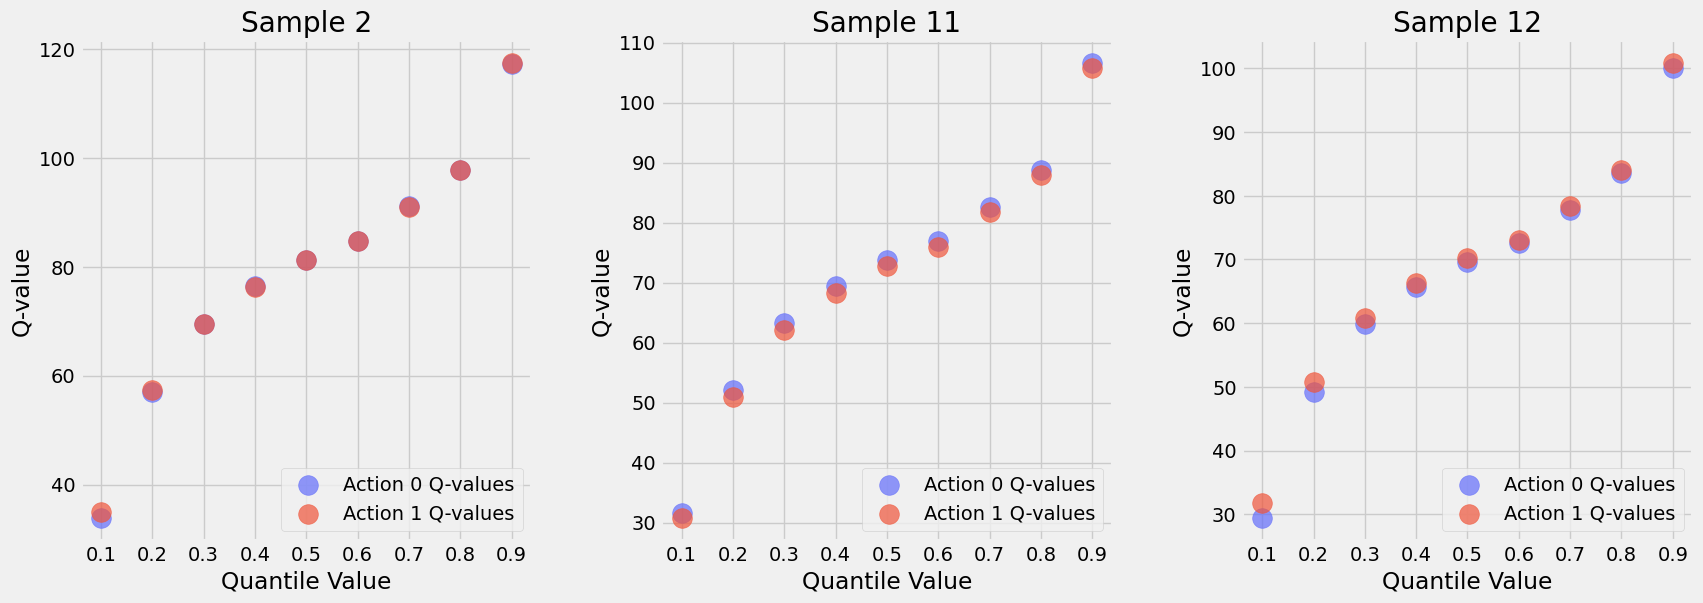

In [8]:
def plot_q_value_distributions(preds, sample_indices=[0]):
    n_samples = len(sample_indices)
    fig, axs = plt.subplots(1, n_samples, figsize=(6*n_samples, 7), squeeze=False)
    
    # Calculate quantile values
    n_quantiles = preds.shape[2]
    quantiles = np.linspace(0, 1, n_quantiles + 2)[1:-1]
    
    for idx, sample_index in enumerate(sample_indices):
        sample_preds = preds[sample_index].detach()
        
        action_0_q_values = sample_preds[0].cpu().numpy()
        action_1_q_values = sample_preds[1].cpu().numpy()
        
        axs[0, idx].scatter(quantiles, action_0_q_values, color='#636EFA', s=200, alpha=0.7, label='Action 0 Q-values')
        axs[0, idx].scatter(quantiles, action_1_q_values, color='#EF553B', s=200, alpha=0.7, label='Action 1 Q-values')
        
        axs[0, idx].set_title(f'Sample {sample_index}')
        axs[0, idx].set_xlabel('Quantile Value')
        axs[0, idx].set_ylabel('Q-value')
        axs[0, idx].set_xticks(quantiles)
        axs[0, idx].legend(loc='lower right')
        axs[0, idx].grid(True)
    
    plt.tight_layout(pad=3)
    plt.show()

# # Get states and predictions
states, actions, rewards, next_states, dones = agent.buffer.sample(agent.config['batch_size'])
states = torch.tensor(states, dtype=torch.float32, device=agent.config['device'])
preds = agent.online_network(states)    
    
# Display Q-value distributions
plot_q_value_distributions(preds, [2, 11, 12])